**This notebook does the classification for the number vocabulary in "CLASSIC_MIZTLI_VOICE_NAHUATL.ipynb" using a trained SVM**

In [ ]:
# Install necesary libraries
!pip install https://github.com/kpu/kenlm/archive/master.zip 
!pip install folium==0.2.1
!pip install pyctcdecode==0.3.0
!pip install datasets==2.0.0
!pip install transformers==4.18.0

     \ 542 kB 734 kB/s
  Created wheel for kenlm: filename=kenlm-0.0.0-cp37-cp37m-linux_x86_64.whl size=2333555 sha256=25de380b3503d61119bd19089c567b05cc935b03d1da4e9553c9a07ffaf48661
  Stored in directory: /tmp/pip-ephem-wheel-cache-om2454rz/wheels/3d/aa/02/7b4a2eab5d7a2a9391bd9680dbad6270808a147bc3b7047e4e
Successfully built kenlm
     |████████████████████████████████| 69 kB 4.1 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=5e160c8836fb7f30fd1bfd711ed57a0c279d82f2cc7d4a4e5130b8a179f6cb68
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 43 kB 1.5 MB/s 
     |████████████████████████████████| 383 kB 17.4 MB/s 
  Created wheel for pygtrie: filename=pygtrie-2.4.2-py3-none

In [ ]:
# Install speech recognition from hugging face
!pip install huggingsound
from huggingsound import SpeechRecognitionModel
model = SpeechRecognitionModel("tyoc213/wav2vec2-large-xlsr-nahuatl")

     |████████████████████████████████| 25.3 MB 1.9 MB/s 
     |████████████████████████████████| 312 kB 39.4 MB/s 
     |████████████████████████████████| 3.4 MB 35.0 MB/s 
     |████████████████████████████████| 50 kB 3.6 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149871 sha256=9fc47bf50f2655a1099cc2779a52f1998e22706e12370f3c6832ee2298a109da
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.0.0
    Uninstalling datasets-2.0.0:
      Succ

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/138 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


05/04/2022 03:21:19 - WARNING - root - bos_token <s> not in provided tokens. It will be added to the list of tokens
05/04/2022 03:21:19 - WARNING - root - eos_token </s> not in provided tokens. It will be added to the list of tokens


# COLLECT AUDIO FROM MIC

In [ ]:
# Add all the code to obtain the audio from microphone 
!pip install ffmpeg-python
from scipy.io.wavfile import write

In [ ]:
# To record in Google Collab with the microphone, we lost the original sourse, but here
# is a secondary one https://stackoverflow.com/questions/67709421/how-to-transcribe-the-recording-for-speech-recognization
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
# Test that the michophone audio function works
# audio, sr = get_audio()
# write("example.wav", 44100, audio)

In [ ]:
# Transcribe the saved file example.wav
# audio_paths = ["./example.wav"]
# model.transcribe(audio_paths)

In [ ]:
# Upload the libriaries for the algorithm
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk import SnowballStemmer
from sklearn.metrics import classification_report

In [ ]:
# Read the possible variations of the 'number word' as transcribed by the speech model and by another dialects/ortographic conventions
# obtained from the file "word.csv"
df = pd.read_csv('word.csv')
df

,numero,texto
0,uno,sem
1,uno,se:
2,uno,se
3,uno,seya
4,uno,ce
...,...,...
656,nueve,chiknaui
657,nueve,chiknawe
658,nueve,chignaue
659,nueve,chignawe


# TRANSLATE NAHUATL NUMBERS INTO TEXT NUMBERS IN SPANISH

In [ ]:
# Separate between test and train datasets
X = df.texto
Y = df.numero

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [ ]:
# Use a Support Vecotr Machine to classify the output of the Speech model
from sklearn.svm import LinearSVC
svc = Pipeline([('vect', CountVectorizer(ngram_range=(1,5),max_df=1000,min_df=1)),
                ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC()),#loss='squared_hinge',tol=1e-2,max_iter=5000
               ])
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9699248120300752
              precision    recall  f1-score   support

       cinco       1.00      1.00      1.00        19
      cuatro       1.00      1.00      1.00        13
         dos       1.00      1.00      1.00        18
       nueve       0.84      1.00      0.91        21
        ocho       1.00      0.80      0.89        20
        seis       1.00      1.00      1.00        13
       siete       1.00      1.00      1.00        14
         uno       1.00      1.00      1.00        15

    accuracy                           0.97       133
   macro avg       0.98      0.97      0.98       133
weighted avg       0.97      0.97      0.97       133



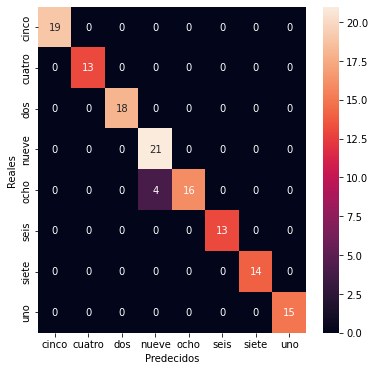

In [44]:
# Test the model with the test dataset to check its accuracy, plotted as a confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred, labels=['cinco', 'cuatro', 'dos', 'nueve', 'ocho', 'seis', 'siete', 'uno'])
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d'
           )
ax.set_xticklabels(['cinco', 'cuatro', 'dos', 'nueve', 'ocho', 'seis', 'siete', 'uno'])
ax.set_yticklabels(['cinco', 'cuatro', 'dos', 'nueve', 'ocho', 'seis', 'siete', 'uno'])
plt.ylabel('Reales')
plt.xlabel('Predecidos')
plt.show()

In [45]:
# Mount in the colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [46]:
# Save the model as svc.pkl
import joblib
joblib.dump(svc, '/content/svc.pkl', compress = 1)

['/content/svc.pkl']